# Session 10

## Cloning the repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Github/
! git config --global user.email "me18b059@smail.iitm.ac.in"

!git clone "https://github.com/Madhur-1/ERA-v1"

/content/drive/MyDrive/Github
Cloning into 'ERA-v1'...
remote: Enumerating objects: 506, done.
remote: Counting objects: 100% (302/302), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 506 (delta 156), reused 274 (delta 131), pack-reused 204
Receiving objects: 100% (506/506), 420.75 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (214/214), done.
Updating files: 100% (116/116), done.


In [3]:
%cd /content/drive/MyDrive/Github/ERA-v1

/content/drive/MyDrive/Github/ERA-v1


In [ ]:
! git config --global user.email "me18b059@smail.iitm.ac.in"
! git config --global  pull.ff true
! git stash push --include-untracked
! git stash drop
! git pull

Saved working directory and index state WIP on master: 2ef0f9c S11 commit 91.41%
Dropped refs/stash@{0} (6468d6cf77b8743dd9322d9203f681999e89f1d0)
<ive/MyDrive/Github/ERA-v1/.git/MERGE_MSG" 6L, 286B▽  Pzz\[0%m           [>c]10;?]11;?Merge branch 'master' of https://github.com/Madhur-1/ERA-v1
# Please enter a commit message to explain why this merge is necessary,# especially if it merges an updated upstream into a topic branch.#
# Lines starting with '#' will be ignored, and an empty message aborts
# the commit.
~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                               ~                                                                          

In [4]:
%cd S12/

/content/drive/MyDrive/Github/ERA-v1/S12


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [5]:
!pip install torchmetrics
!pip install torch_lr_finder
!pip install pytorch_lightning

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# del model
import torch
import torch.nn as nn
import torch.optim as optim
from Utilities.model import Net
from Utilities.utils import train, test
import torch.nn.functional as F
from torchsummary import summary
from Utilities import config

torch.manual_seed(config.SEED)

# Model Initialization & Summary

In [8]:
criterion = F.cross_entropy

model = Net(
    num_classes=config.NUM_CLASSES,
    dropout_percentage=config.DROPOUT_PERCENTAGE,
    norm=config.LAYER_NORM,
    criterion=criterion,
    learning_rate=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY)

summary(model.to(config.ACCELERATOR), input_size=config.INPUT_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

# Dataset & Dataloaders

In [9]:
from Utilities.transforms import train_transforms, test_transforms

In [10]:
from Utilities.dataset import CIFAR10DataModule

kwargs = {'batch_size': config.BATCH_SIZE,
          'shuffle': config.SHUFFLE,
          'num_workers': config.NUM_WORKERS,
          'pin_memory': config.PIN_MEMORY}
data_module = CIFAR10DataModule(train_transforms=train_transforms, val_transforms=test_transforms, **kwargs)

In [12]:
# Call the setup() method before train_dataloader()
data_module.prepare_data()
data_module.setup(stage=None)

# Now you can call train_dataloader()
train_loader = data_module.train_dataloader()

100%|██████████| 170498071/170498071 [00:02<00:00, 75336350.69it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Exploration

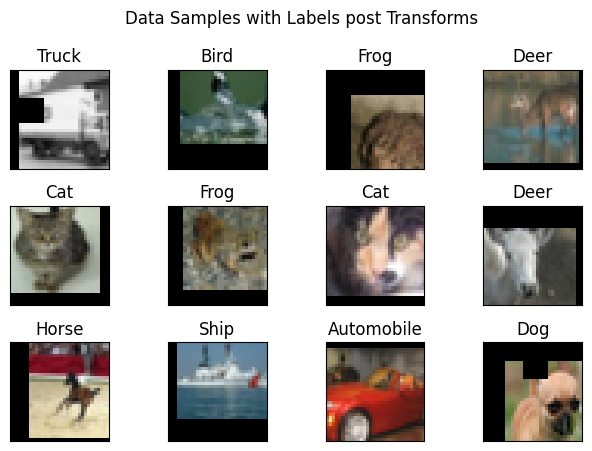

In [ ]:
from Utilities.visualize import plot_data_samples, plot_class_label_counts

# plot_class_label_counts(train_loader, classes=config.CLASSES)
plot_data_samples(train_loader, classes=config.CLASSES)

# Training

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


  0%|          | 0/30 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.74E-03


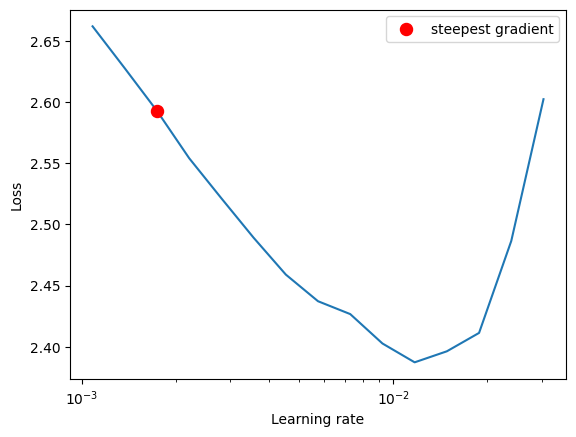

LRFinder Best LR:  0.0017433288221999881


Sanity Checking: 0it [00:00, ?it/s]


Epoch: 0, Val Loss: 2.303018569946289, Val Accuracy: 0.0927734375
{'train_loss_epoch': [], 'train_acc_epoch': [], 'val_loss_epoch': [2.303018569946289], 'val_acc_epoch': [0.0927734375], 'test_loss_epoch': [], 'test_acc_epoch': []}


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Epoch: 0, Val Loss: 1.6124155521392822, Val Accuracy: 0.4422000050544739
{'train_loss_epoch': [], 'train_acc_epoch': [], 'val_loss_epoch': [2.303018569946289, 1.6124155521392822], 'val_acc_epoch': [0.0927734375, 0.4422000050544739], 'test_loss_epoch': [], 'test_acc_epoch': []}

Epoch: 0, Train Loss: 1.8321170806884766, Train Accuracy: 0.340939998626709


Validation: 0it [00:00, ?it/s]


Epoch: 1, Val Loss: 1.1174349784851074, Val Accuracy: 0.6067000031471252
{'train_loss_epoch': [1.8321170806884766], 'train_acc_epoch': [0.340939998626709], 'val_loss_epoch': [2.303018569946289, 1.6124155521392822, 1.1174349784851074], 'val_acc_epoch': [0.0927734375, 0.4422000050544739, 0.6067000031471252], 'test_loss_epoch': [], 'test_acc_epoch': []}

Epoch: 1, Train Loss: 1.2134642601013184, Train Accuracy: 0.5662800073623657


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Training, validation, and testing completed!
{'train_loss_epoch': [1.8321170806884766, 1.2134642601013184], 'train_acc_epoch': [0.340939998626709, 0.5662800073623657], 'val_loss_epoch': [2.303018569946289, 1.6124155521392822, 1.1174349784851074], 'val_acc_epoch': [0.0927734375, 0.4422000050544739, 0.6067000031471252], 'test_loss_epoch': [], 'test_acc_epoch': []}


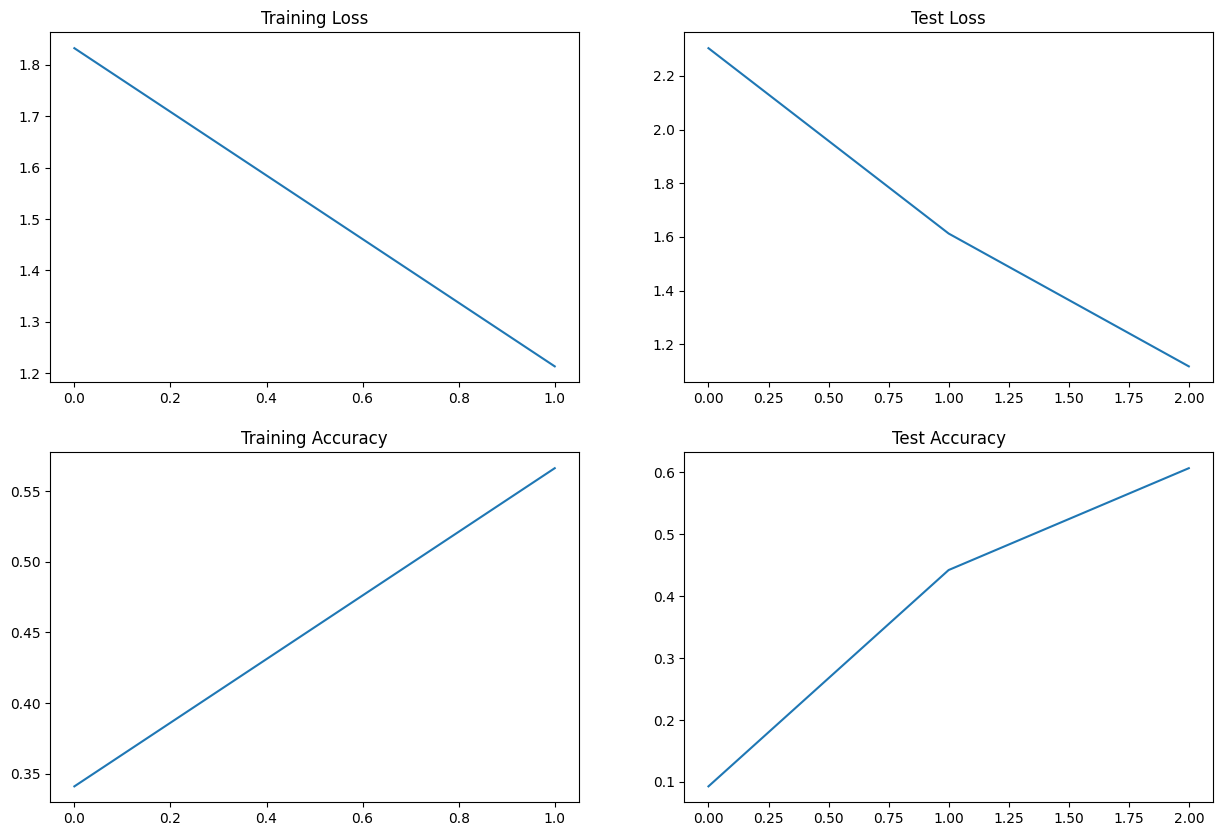

In [16]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelSummary
from Utilities.callbacks import TrainingEndCallback, PrintLearningMetricsCallback

trainer = pl.Trainer(accelerator=config.ACCELERATOR,
                     callbacks=[ModelSummary(max_depth=0), TrainingEndCallback(), PrintLearningMetricsCallback()],
                     min_epochs=config.NUM_EPOCHS, max_epochs=config.NUM_EPOCHS)
trainer.fit(model, datamodule=data_module)

# Testing & Evaluation

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]


Epoch: 2, Test Loss: 1.1174349784851074, Test Accuracy: 0.6067000031471252


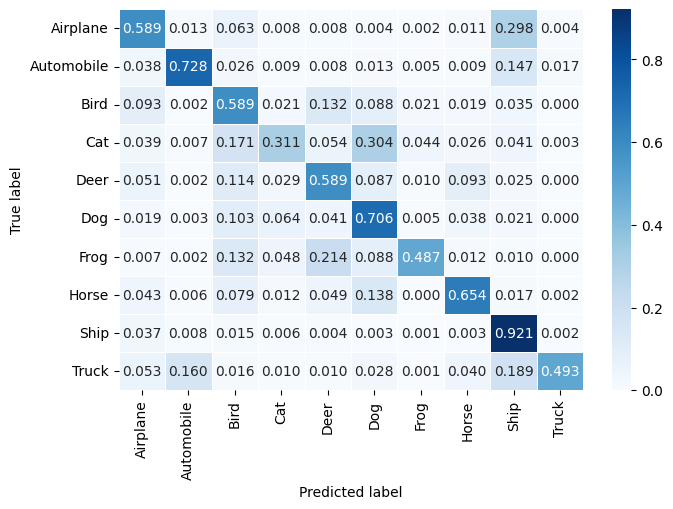

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.6067000031471252     │
│      test_loss_epoch      │    1.1174349784851074     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 1.1174349784851074, 'test_acc_epoch': 0.6067000031471252}]

In [17]:
trainer.test(model=model, datamodule=data_module, verbose=True)

Total Incorrect Predictions 3933


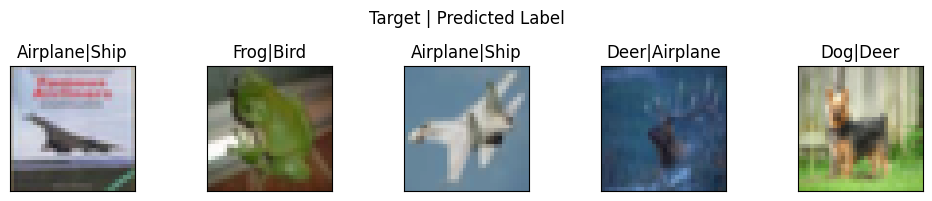

In [18]:
model.plot_incorrect_predictions_helper(num_imgs=5)

# Saving the model

In [153]:
torch.save(model.state_dict(), config.MODEL_SAVE_PATH)

### Git Push

In [ ]:
!git add .
! git commit -m "S10 commit 92.82%"
! git push

[master aec4fcf] S10 commit 92.82%
 2 files changed, 27 insertions(+), 27 deletions(-)
 rewrite S10/Store/training_stats.csv (93%)
Enumerating objects: 13, done.
Counting objects: 100% (13/13), done.
Delta compression using up to 2 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (7/7), 1.21 KiB | 310.00 KiB/s, done.
Total 7 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Madhur-1/ERA-v1
   3352787..aec4fcf  master -> master
